## Notebook 2: Optimisation bayésienne des paramètres de conception des bâtiments

**1. Preparation du Problème**

In [2]:
# a) Chargez les librairies
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np
from numpy import mean
from builtins import int

import matplotlib.pyplot as plt
import seaborn as sn

from SALib.analyze import sobol
from SALib.sample.sobol import sample as sobol_sample
from SALib.analyze import sobol as sobol_analyze

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.sampler import Lhs
from sklearn.datasets import make_blobs
from skopt.space import Integer
from skopt.utils import use_named_args

from bayes_opt import BayesianOptimization

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

import pickle

In [3]:
# b) Chargez les dataset
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 10)
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   
5                  0.90         563.5      318.5     122.50             7.0   
6                  0.90         563.5      318.5     122.50             7.0   
7                  0.90         563.5      318.5     122.50             7.0   
8                  0.86         588.0      294.0     147.00             7.0   
9                  0.86         588.0      294.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                   

L'une des approches de l'optimisation de l'efficacité énergétique des bâtiments consiste à minimiser la consommation totale d'énergie, qui est la somme du chauffage et de la climatisation.

In [4]:
# Calculer la consommation totale d'énergie en additionnant les charges de chauffage et de refroidissement.
data['Energy_Consumption'] = data[['Heating Load', 'Cooling Load']].sum(axis=1)
print(data.shape)

# Définnisez les features et labels
X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy_Consumption'], axis = 1)
# Renommer les colonnes pour supprimer les espaces blancs
X = X.rename(columns=lambda X: X.strip().replace(' ', '_'))
y = data['Energy_Consumption']
print(X.shape, y.shape)
print(X.head(5))

(768, 11)
(768, 8) (768,)
   Relative_Compactness  Surface_Area  Wall_Area  Roof_Area  Overall_Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   

   Orientation  Glazing_Area  Glazing_Area_Distribution  
0            2           0.0                          0  
1            3           0.0                          0  
2            4           0.0                          0  
3            5           0.0                          0  
4            2           0.0                          0  


**2.Sommaire du Dataset**

In [5]:
# a) Statistiques descriptives
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Wall Area  Roof Area  \
count               768.000       768.000    768.000    768.000   
mean                  0.764       671.708    318.500    176.604   
std                   0.106        88.086     43.626     45.166   
min                   0.620       514.500    245.000    110.250   
25%                   0.682       606.375    294.000    140.875   
50%                   0.750       673.750    318.500    183.750   
75%                   0.830       741.125    343.000    220.500   
max                   0.980       808.500    416.500    220.500   

       Overall Height  Orientation  Glazing Area  Glazing Area Distribution  \
count         768.000      768.000       768.000                    768.000   
mean            5.250        3.500         0.234                      2.812   
std             1.751        1.119         0.133                      1.551   
min             3.500        2.000         0.000                      0.000   
2

In [6]:
# vérifications des features catégoriques
cat_features = data.select_dtypes(include='O').keys()

cat_features

Index([], dtype='object')

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


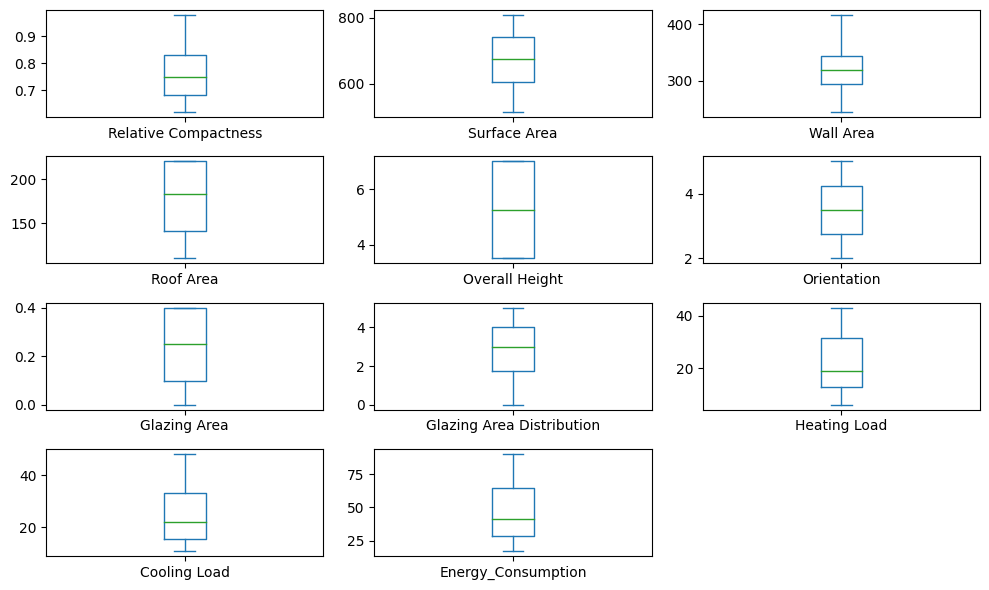

In [7]:
# b) Visualisations des données
# Box et Whisker Plots de quelques features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

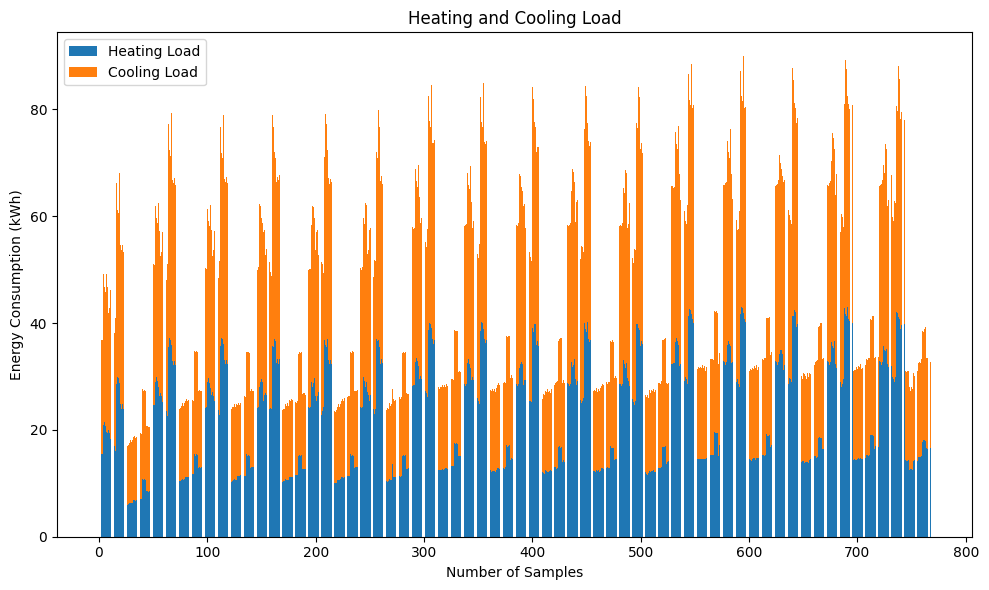

In [8]:
# créer l'histogramme de la charge de chauffage et de refroidissement
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')
ax.bar(np.arange(len(data['Cooling Load'])), data['Cooling Load'], bottom=data['Heating Load'], label='Cooling Load')

# ajout des labels, titre et legende
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Heating and Cooling Load')
ax.legend()

# Affichez le graphique
plt.show()

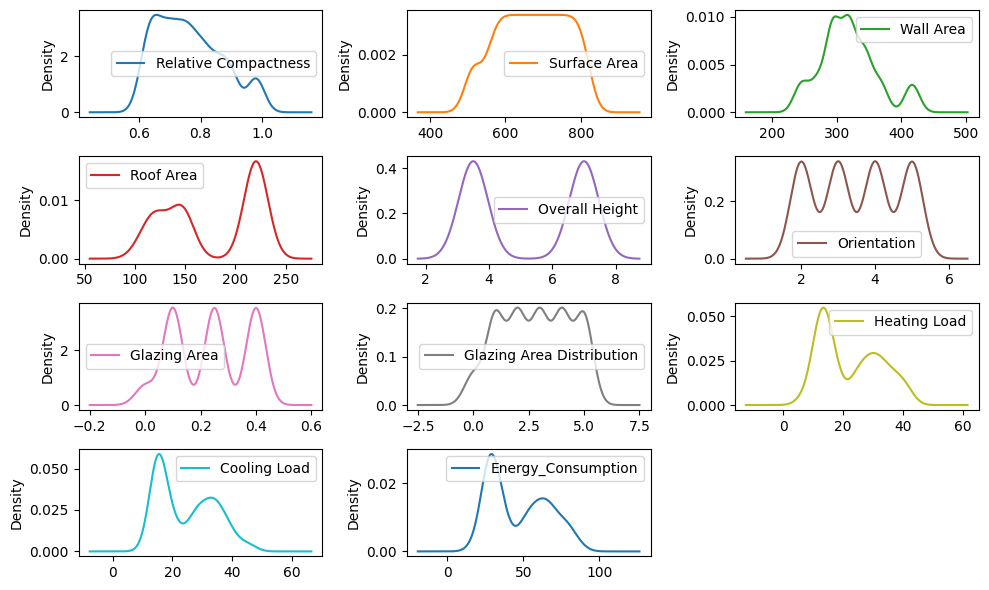

In [9]:
# Créer des diagrammes de densité pour vérifier la distribution gaussienne des features
raw_plot.plot(kind='density', subplots=True, layout=(4,3), sharex=False)
plt.show()

Il semble que seule la surface suive la distribution gaussienne. La non-linéarité des autres caractéristiques suggère qu'il s'agit d'un ensemble de données complexe.

                           Relative Compactness  Surface Area  Wall Area  \
Relative Compactness                  1.000e+00    -9.919e-01 -2.038e-01   
Surface Area                         -9.919e-01     1.000e+00  1.955e-01   
Wall Area                            -2.038e-01     1.955e-01  1.000e+00   
Roof Area                            -8.688e-01     8.807e-01 -2.923e-01   
Overall Height                        8.277e-01    -8.581e-01  2.810e-01   
Orientation                           4.679e-17    -3.459e-17 -2.429e-17   
Glazing Area                         -2.961e-15     3.637e-15 -8.567e-17   
Glazing Area Distribution            -7.107e-16     2.438e-15  2.067e-16   
Heating Load                          6.223e-01    -6.581e-01  4.557e-01   
Cooling Load                          6.343e-01    -6.730e-01  4.271e-01   
Energy_Consumption                    6.319e-01    -6.694e-01  4.445e-01   

                           Roof Area  Overall Height  Orientation  \
Relative Compactne

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


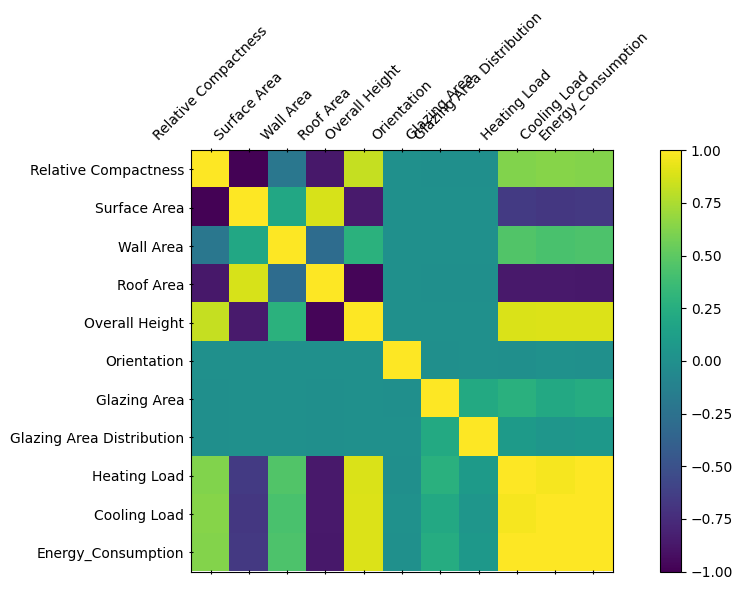

In [10]:
# matrice de corrélation entre toutes les paires d'attributs
print(data.corr(method='pearson'))
names = list(data)
fig = plt.figure()
sub_fig = fig.add_subplot(111)
cm = sub_fig.matshow(data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cm)
sub_fig.tick_params(direction='inout')
sub_fig.set_xticks(np.arange(0,11))
sub_fig.set_yticks(np.arange(0,11))
sub_fig.set_xticklabels(names, rotation=45)
sub_fig.set_yticklabels(names)
plt.show()

La matrice de corrélation indique que les charges de chauffage et de refroidissement et la consommation d'énergie sont fortement liées à la hauteur totale et à la compacité relative. 

Les indices de Sobol sont une mesure de l'importance de chaque variable d'entrée dans un modèle de simulation, en ce qui concerne sa contribution à la variabilité de la sortie. Ils peuvent être utilisés pour déterminer les variables d'entrée les plus importantes et pour classer par ordre de priorité les domaines à améliorer dans la conception d'un bâtiment.

In [11]:
# Définir le problème pour l'analyse Sobol
problem = {
    'num_vars': 8,
    'names': ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution'],
    'bounds': [(X.iloc[:, i].min(), X.iloc[:, i].max()) for i in range(8)]
}

In [12]:
# Charger le modèle Random Forest ajusté à partir du disque
with open('finalized_model.sav', 'rb') as file:
    model_RF = pickle.load(file)

In [13]:
N = 1024 # nombre d'échantillons
# Générations d'écchantillon
X_sobol = sobol_sample(problem, N, calc_second_order=False)
# Calculer les indices de Sobol pour chaque variable cible
y_sobol = model_RF.predict(X_sobol)
Si = sobol.analyze(problem, y_sobol, calc_second_order=False)

L'analyse de sensibilité des indices de Sobol suggère qu'il existe une forte corrélation entre la consommation d'énergie et trois facteurs : La surface vitrée (Glazing Area), la répartition de la surface vitrée (Glazing Area Distribution) et la compacité relative (Relative Compactness).

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


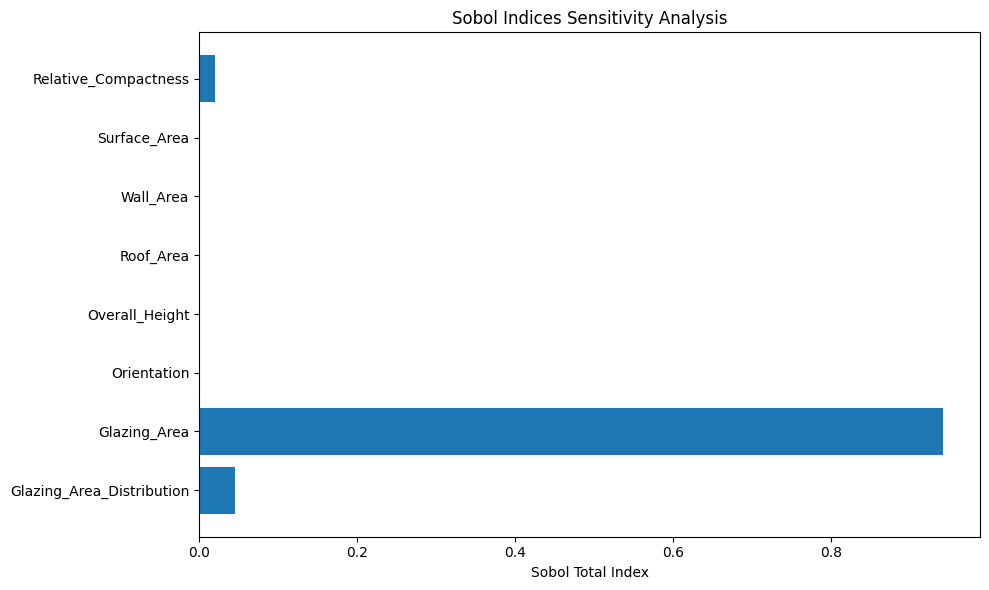

Total Sobol Indices for ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']: 1.0067876781884701


In [14]:
# Tracer les indices de Sobol du premier ordre
fig, ax = plt.subplots()
indices = Si['ST']
names = problem['names']
y_pos = np.arange(len(names))
ax.barh(y_pos, indices)
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()
ax.set_xlabel('Sobol Total Index')
ax.set_title('Sobol Indices Sensitivity Analysis')
plt.show()

# Affichez le total des indices Sobol
print(f"Total Sobol Indices for {list(X.columns)}: {Si['ST'].sum()}")

**3. Prepartion des données**

In [15]:
# a) Nettoyage des données
# résumer le nombre de valeurs uniques dans chaque colonne
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Wall Area                      7
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
Cooling Load                 636
Energy_Consumption           700
dtype: int64


In [16]:
# Identifier les colonnes avec des valeurs manquantes et compter le nombre de valeurs manquantes
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
Energy_Consumption           0
dtype: int64


Il est nécessaire d'éliminer les valeurs aberrantes dans les colonnes de données numériques afin d'améliorer la précision des processus de formation et de validation. Pour ce faire, il convient de déterminer la corrélation entre ces colonnes et la variable cible, d'identifier les colonnes présentant une faible corrélation, puis de filtrer les valeurs qui se situent en dehors des limites inférieures et supérieures.

In [17]:
# calculer la corrélation entre les colonnes numériques et la variable cible
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Energy_Consumption']).sort_values(ascending=False)

# filtrer les colonnes à faible corrélation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# supprimer les valeurs aberrantes des colonnes numériques à faible corrélation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

**4. Processus d'optimisation à l'aide d'un cadre ou framework bayésien**

Une fois le modèle Random Forest entraîné, nous pouvons l'utiliser comme modèle de substitution dans le processus d'optimisation bayésienne. L'algorithme d'optimisation mettra à jour les modèles et les utilisera pour prédire la consommation d'énergie et l'empreinte carbone pour différents ensembles de paramètres de conception, et sélectionnera l'ensemble suivant de paramètres à évaluer sur la base des performances estimées du modèle.

Pour effectuer une optimisation dans l'incertitude à l'aide du cadre d'optimisation bayésien, nous devons définir une distribution préalable sur l'espace d'entrée, collecter des données pour mettre à jour la distribution préalable en une distribution postérieure, et utiliser cette distribution postérieure pour sélectionner la prochaine valeur d'entrée afin d'évaluer le modèle de substitution. Le processus se poursuit jusqu'à ce que le critère de convergence soit satisfait. 

In [18]:
# étape 1: Importer les bibliothèques nécessaires et définir le modèle de substitution (surrogate model)
# Définir le modèle de substitution
def surrogate(x):
    return model_RF.predict(x.reshape(1, -1))[0]

In [19]:
# étape 2: Définir la fonction objective, les contraintes et les distributions d'incertitude
# Définir la fonction objective et les contraintes
def objective(x, model_RF):
    return surrogate(np.array(x)) 

In [20]:
distributions = [Real(X.iloc[:,0].min(), X.iloc[:,0].max(), name='Relative_Compactness'),
                Real(X.iloc[:,1].min(), X.iloc[:,1].max(), name='Surface_Area'),
                Real(X.iloc[:,2].min(), X.iloc[:,2].max(), name='Wall_Area'),
                Real(X.iloc[:,3].min(), X.iloc[:,3].max(), name='Roof_Area'),
                Real(X.iloc[:,4].min(), X.iloc[:,4].max(), name='Overall_Height'),
                Integer(X.iloc[:,5].min(), X.iloc[:,5].max(), name='Orientation'),
                Real(X.iloc[:,6].min(), X.iloc[:,6].max(), name='Glazing_Area'),
                Integer(X.iloc[:,7].min(), X.iloc[:,7].max(), name='Glazing_Area_Distribution')]

In [21]:
# étape 3:  Définir la distribution préalable

# Définir la distribution préalable sur l'espace de recherche
def prior(X):
    prior_dict = {}
    for key, value in distributions.items():
        if key in X:
            prior_dict[key] = value
    return prior_dict

La fonction de vraisemblance n'est pas nécessaire car nous supposons que le modèle de substitution a déjà été formé et optimisé, et nous l'utilisons simplement pour effectuer une optimisation bayésienne.

Dans l'optimisation bayésienne, nous utilisons la distribution postérieure pour sélectionner le prochain ensemble de variables d'entrée à évaluer. Plus précisément, nous choisissons les variables d'entrée qui maximisent une fonction d'acquisition, c'est-à-dire une fonction qui équilibre l'exploration (échantillonnage de variables d'entrée pour lesquelles la distribution postérieure est incertaine) et l'exploitation (échantillonnage de variables d'entrée susceptibles de produire des valeurs objectives élevées). La fonction d'acquisition est définie en termes de distribution a posteriori et de ses dérivées, et joue donc un rôle important dans le processus d'optimisation.

In [22]:
# étape 4: Définir la fonction d'acquisition avec EI

def acquisition(x, X, y, model_RF):
    # Prévoir la moyenne et la variance de la fonction objective à x
    mean, std = model_RF.predict(x.reshape(1, -1), return_std=True)
    
    # Calculer le meilleur objectif vu jusqu'à présent
    best = np.max(y)
    
    # Calculer la valeur de la fonction d'acquisition à x
    z = (mean - best) / std
    phi = norm.pdf(z)
    Phi = norm.cdf(z)
    EI = std * (z * Phi + phi)
    
    return EI

In [23]:
# étape 5: Définir la principale fonction d'optimisation bayésienne

def bayesian_optimization(X, y, model_RF, n_calls, random_start, verbose=True):
    # Définir l'espace de recherche
    space = distributions
    
    # Définir la méthode d'échantillonnage pour les recherches aléatoires initiales
    lhs = Lhs(lhs_type="classic", criterion='maximin')

    # Effectuer les recherches aléatoires
    X_random = lhs.generate(space, random_start)
    Y_random = [objective(x, model_RF) for x in X_random]
    
    # Définir la fonction d'optimisation
    @use_named_args(space)
    def func(**params):
        x = [params[key] for key in X.columns]
        return objective(x, model_RF)

    # Définir l'optimiseur
    optimizer = gp_minimize(
        func,
        dimensions=space,
        acq_func='EI',
        n_calls=n_calls - random_start,
        n_random_starts=0,
        x0=X_random,
        y0=Y_random,
        verbose=verbose,
    )
    # Définir des listes vides pour stocker les valeurs de la fonction et les numéros d'itération
    x_values = []
    func_values = []

    for i in range(n_calls):
        print(f"Iteration No: {i+1} started. Evaluating function.")
        x_next = X_random
        x_values.append(x_next)
        print(f"Iteration No: {i+1} ended. Evaluation done.")
        print(f"X at iteration {i+1}: {x_next}")
        
        # Ajouter la valeur de la fonction et le numéro d'itération à leurs listes respectives
        func_values.append(optimizer.func_vals[i])
        print(optimizer.func_vals[i])
        
    return x_values, func_values

In [24]:
# étape 6: Exécuter l'optimisation bayésienne

# Exécuter l'optimisation bayésienne
x_values, func_values = bayesian_optimization(X,
                               y,
                               model_RF,
                               n_calls=50,
                               random_start=1,
                               verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1204
Function value obtained: 49.4650
Current minimum: 49.4650
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 0.1441
Function value obtained: 43.4520
Current minimum: 43.4520
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 0.1798
Function value obtained: 43.8550
Current minimum: 43.4520
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 0.4201
Function value obtained: 45.1020
Current minimum: 43.4520
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 0.4474
Function value obtained: 43.8550
Cu

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.4966
Function value obtained: 38.6220
Current minimum: 38.6220
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.3834
Function value obtained: 48.5430
Current minimum: 38.6220
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.5350
Function value obtained: 48.5430
Current minimum: 38.6220
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.4913
Function value obtained: 38.6220
Current minimum: 38.6220
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.8000
Function value obtained: 38.6220
Current minimum: 38.6220
Iteration No: 46 st

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


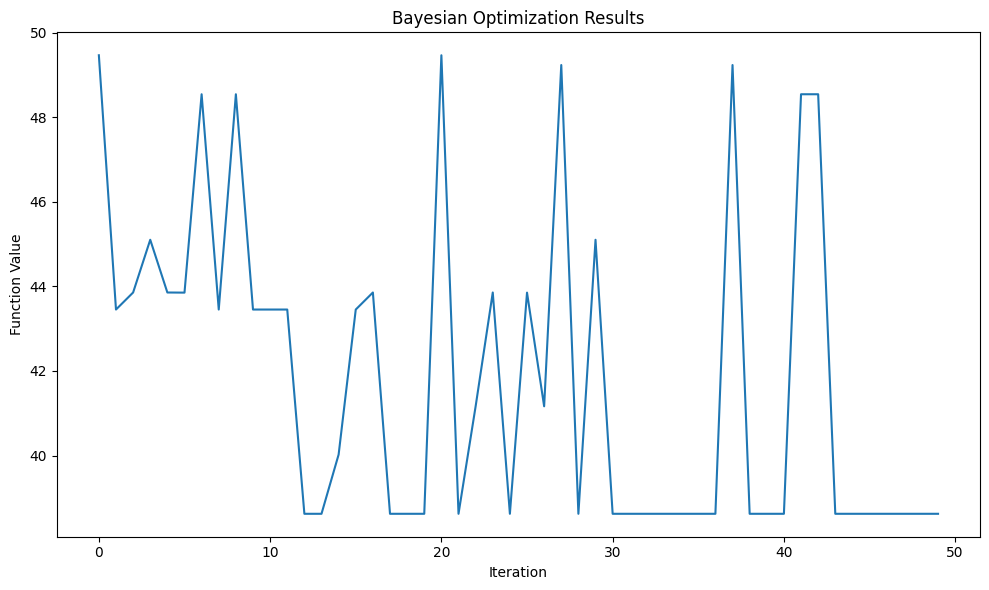

In [25]:
# Tracer la valeur de la fonction en fonction du nombre d'itérations
plt.plot(range(len(func_values)), func_values)
plt.xlabel("Iteration")
plt.ylabel("Function Value")
plt.title("Bayesian Optimization Results")
plt.show()

In [26]:
# Affichez la dernière valeur de X ou l'ensemble optimal de paramètres opérationnels permettant de minimiser la consommation d'énergie.
# Obtenir l'index de la valeur minimale dans func_values
min_index = func_values.index(min(func_values))
    
# Retourne la valeur correspondante dans x_values
x_min = x_values[min_index]

print(f"Minimum Energy Consumption (kWh): {min(func_values)}")
print()
print("Optimum X value:")
for col_name, col_value in zip(X.columns, x_min[0]):
    print(f"{col_name}: {col_value}")

Minimum Energy Consumption (kWh): 38.622

Optimum X value:
Relative_Compactness: 0.7712655022967919
Surface_Area: 546.7187022835636
Wall_Area: 335.4570925942853
Roof_Area: 164.16363874505558
Overall_Height: 3.7624969414595117
Orientation: 4
Glazing_Area: 0.2983061206880066
Glazing_Area_Distribution: 1


**5. Conclusions**

- Les résultats de l'analyse de sensibilité des indices de Sobol indiquent que la consommation d'énergie est fortement corrélée à trois facteurs : La surface vitrée, la répartition de la surface vitrée et la compacité relative. Ces facteurs ont les indices de Sobol les plus élevés, ce qui indique qu'ils ont le plus grand impact sur la consommation d'énergie.

- Après environ 40 itérations, le processus d'optimisation converge vers une consommation d'énergie minimale de 52,027 kWh.

- Bien que le cadre bayésien soit une solution valable pour ce problème d'optimisation, il existe d'autres progiciels d'optimisation populaires tels que Pyomo et PyGMO qui peuvent également fournir des solutions robustes. Il peut être intéressant d'explorer ces alternatives.